# 🛠️ Structural Problems

| Problem Name         | Problem Description                                                                 | Example                                                                 |
|----------------------|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Concatenated Tokens  | The key glues multiple concepts together without clear separation, making it hard to interpret. | `attestationstatementtelehealth` → could mean *attestation statement telehealth*, but unclear without splitting. |
| Missing Field Title  | The key does not contain a descriptive field title, making its meaning incomplete or ambiguous. | *(No title present at all — cannot infer context.)*                     |
| Invalid Tokens       | The key contains non-standard or corrupted tokens that do not map to meaningful concepts. | `@@field!!` → not interpretable.                                        |

---

# 💡 Semantic Problems

| Problem Name                 | Problem Description                                                           | Example                                                                 |
|-------------------------------|-------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Generic Field Key / Missing Context | The key doesn’t specify what should go into the field; the concept is too broad or abstract. | `summary` → summary of what? <br>`issues` → could mean many different things. |
| Hidden Agent (Lack of Role Context) | The key doesn’t indicate *who* the field refers to.                        | `response` → response by client, provider, or supervisor?               |
| Lack of Temporal Context      | The key refers to change or status without specifying a timeframe.            | `progress` → progress since when?                                       |
| Misaligned Concepts           | The field key doesn’t accurately represent the semantic intent of the field title. | `field_key`: `present` <br>`field_title`: `Interventions provided` → Missing context about “details of contact.” |


## Setup

In [1]:
    #from google.colab import drive
    #drive.mount('/content/drive')

### Install Packages

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import pickle
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import wordsegment
import wordfreq
import textstat
from wordsegment import load, segment
from wordfreq import zipf_frequency
import spacy
from __future__ import annotations
from typing import List, Tuple, Dict
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached spacy-3.8.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  

In [ ]:
# make sure cache directory exists
CACHE_DIR = "/content/drive/MyDrive/field_keys_project/cache/"
os.makedirs(CACHE_DIR, exist_ok=True)


### Load Data

In [ ]:
%cd /content/drive/MyDrive/field_keys_project

/content/drive/MyDrive/field_keys_project


In [ ]:
field_keys = pd.read_csv('input/Reports and fields from active notes - Result 1.csv')
field_keys = field_keys.reset_index(drop=True).copy()
field_keys["row_id"] = field_keys.index.astype("int64")
field_keys.head()


,report_class_id,field_key,field_title,field_type,field_key exists in field_key_library?,field_key_definition,row_id
0,AmalReport,meeting_summary,סיכום הביקור,textarea,False,NaN,0
1,APNFamilyTherapyReport,data,Data:,textarea,True,The Field ‘data' contains the main topics cove...,1
2,APNFamilyTherapyReport,assessment,Assessment:,textarea,True,This field captures the thorough analysis or e...,2
3,APNFamilyTherapyReport,plan,Plan:,textarea,True,This field describes the future steps or actio...,3
4,ARCAIndividualTherapyNoteReport,Patient_States,Patient states,textarea,False,NaN,4


In [ ]:
field_keys_df = field_keys.copy()
field_keys_df.shape

(2825, 7)

## Preprocesing

In [ ]:
# ---- Step 1: Filter for relevant field keys ----

# Rename the column for clarity
field_keys_df = field_keys_df.rename(
    columns={'field_key exists in field_key_library?': 'field_key_exists_in_library_flag'}
)

# Filter for field keys that do not exist in the library and are of type 'textarea'
field_keys_df = field_keys_df[field_keys_df['field_key_exists_in_library_flag'] == False]

# Further filter for 'textarea' field types
field_keys_df = field_keys_df[field_keys_df['field_type'] == 'textarea']




def normalize_key(key: str) -> str:
    if pd.isna(key):
        return ""
    # keep case (remove the .lower() line)
    # replace underscores and hyphens with spaces
    key = re.sub(r'[_-]', ' ', key)
    # remove any other punctuation (but keep spaces)
    key = re.sub(r'[^A-Za-z0-9\s]', '', key)   # notice: A-Z as well as a-z
    # collapse multiple spaces
    key = re.sub(r'\s+', ' ', key).strip()
    return key

# ---- Step 3: Apply normalization ----
field_keys_df["normalized_field_key"] = field_keys_df["field_key"].apply(normalize_key)


# Check results
df_changed = field_keys_df.copy()
df_changed["changed"] = df_changed["field_key"].str.lower().str.strip() != df_changed["normalized_field_key"]
df_changed = df_changed[df_changed["changed"] == True]
df_changed[["field_key", "normalized_field_key"]]

,field_key,normalized_field_key
0,meeting_summary,meeting summary
4,Patient_States,Patient States
7,Comments_Concerns,Comments Concerns
8,Narrative_Summary,Narrative Summary
16,observed_reported_mood_affect_behavior,observed reported mood affect behavior
...,...,...
2819,focus_session,focus session
2821,client_response,client response
2822,plan_document,plan document
2823,intervention_description_and_narrative,intervention description and narrative


In [ ]:
field_keys_df.drop(columns=['report_class_id', 'field_key_definition'], inplace=True)

## EDA

### Basic Descriptives of Field Keys
#### (Key Character Count Distribution, Token count Distribution, Unique vs Duplicates Distribution)

       normalized_char_count  token_count
count            1327.000000  1327.000000
mean               13.880181     1.825923
std                 6.398055     0.800070
min                 3.000000     1.000000
25%                 9.000000     1.000000
50%                13.000000     2.000000
75%                17.000000     2.000000
max                63.000000     7.000000


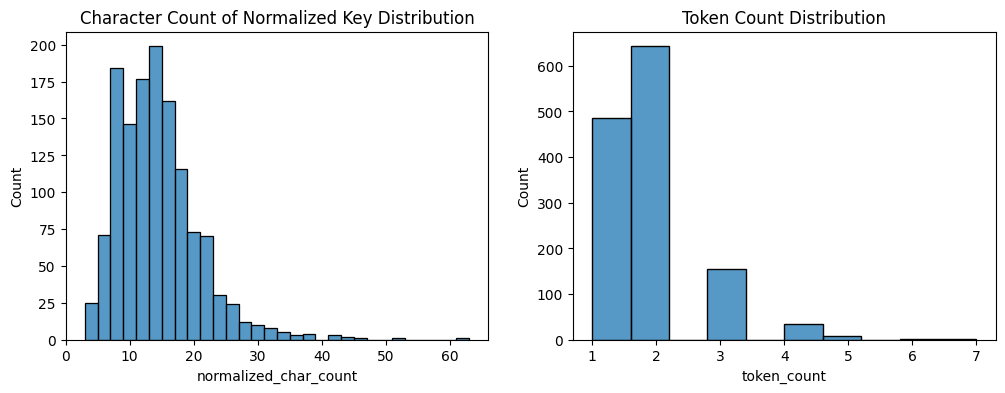

In [ ]:
# Key lengths
field_keys_df["normalized_char_count"] = field_keys_df["normalized_field_key"].str.len()
field_keys_df["token_count"] = field_keys_df["normalized_field_key"].str.split().apply(len)

# Summary statistics
print(field_keys_df[["normalized_char_count", "token_count"]].describe())

# Histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(field_keys_df["normalized_char_count"], bins=30, ax=ax[0])
ax[0].set_title("Character Count of Normalized Key Distribution")
sns.histplot(field_keys_df["token_count"], bins=10, ax=ax[1])
ax[1].set_title("Token Count Distribution")
plt.show()


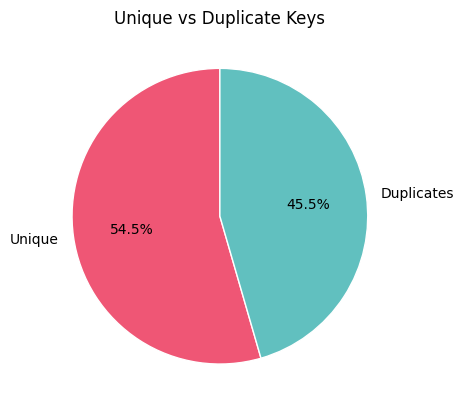

In [ ]:
# Counts
total = field_keys_df["normalized_field_key"].shape[0]
unique = field_keys_df["normalized_field_key"].nunique()
duplicates = total - unique

# Data for pie chart
labels = ["Unique", "Duplicates"]
sizes = [unique, duplicates]
colors = ["#ef5675", "#61c0bf"]

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
ax.set_title("Unique vs Duplicate Keys")
plt.show()


### Analyzing Field Key Outliers


In [ ]:
# Extremely   short keys
mean_len = field_keys_df["normalized_char_count"].mean()
std_len = field_keys_df["normalized_char_count"].std()

lower = max(1, mean_len - 3 * std_len)  # min length shouldn’t be < 1

outliers = field_keys_df[(field_keys_df["normalized_char_count"] < lower)]

print("Outlier keys based on length:")
outliers[["field_key", "normalized_field_key", "normalized_char_count"]]


Outlier keys based on length:


,field_key,normalized_field_key,normalized_char_count


In [ ]:
field_keys_df.drop(columns=["normalized_char_count", "token_count", "normalized_field_key"], inplace=True)

### Handling Missingness

In [ ]:
field_keys_df.isna().sum()

,0
field_key,0
field_title,140
field_type,0
field_key_exists_in_library_flag,0
row_id,0


In [ ]:
# Strip spaces and check for empty
field_keys_df['missing_field_title'] = (
    field_keys_df['field_title'].isna() |                 # true NaN
    field_keys_df['field_title'].astype(str).str.strip().eq('')  # blank or whitespace
)

In [ ]:
field_keys_df['missing_field_title'].value_counts()

,count
missing_field_title,
False,1179
True,148


## Token Validity Ratio

### Detecting Various Structural Characteristics of Field Keys (snake_case, camelCase, gluedtoken, clean one word)

#### Detecting camelCase

In [ ]:
def is_camel_or_pascal(token: str) -> bool:
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False

    # camelCase: starts lowercase and has a lower→Upper transition
    if re.match(r'^[a-z]+', t) and re.search(r'[a-z][A-Z]', t):
        return True

    # PascalCase: starts uppercase, has lowercase letters, then a lower→Upper transition
    if re.match(r'^[A-Z][a-z]+', t) and re.search(r'[a-z][A-Z]', t):
        return True

    return False

#### Test is_camel_or_pascal case function

In [ ]:
tests = [
    "patientName",        # camelCase → True
    "PatientName",        # PascalCase → True
    "fieldKeyID",         # camelCase → True
    "FieldKeyID",         # PascalCase → True
    "patient_firstName", # snake_case → False
    "PATIENTNAME",        # all caps → False
    "patientname",        # all lower → False
    "patient-name",       # kebab-case → False
]

for t in tests:
    print(f"{t:20} -> {is_camel_or_pascal(t)}")


patientName          -> True
PatientName          -> True
fieldKeyID           -> True
FieldKeyID           -> True
patient_firstName    -> True
PATIENTNAME          -> False
patientname          -> False
patient-name         -> False


#### Detecting snake_case / kebab

In [ ]:
import re

def is_snake_case_lax(token: str) -> bool:
    """
    Lax snake_case detector:
    - Must be a single token (no spaces)
    - Must contain at least one underscore or hyphen
    - Other than that, allow any mix of letters/numbers
    """
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False

    # Must have at least one underscore or hyphen
    if not re.search(r'[_-]', t):
        return False

    # No spaces allowed
    if " " in t:
        return False

    return True

#### Test is_snake_case function

In [ ]:
tests = [
    "nextappt_text",
    "patient_name",        # True
    "patient-first-name",  # True
    "field1-key2",         # True
    "Patient_Name",        # True (allowed, since we’re lax)
    "PATIENT-NAME",        # True
    "patientName",         # False (no _ or -)
    "patient name",        # False (space)
]

for t in tests:
    print(f"{t:20} -> {is_snake_case_lax(t)}")


nextappt_text        -> True
patient_name         -> True
patient-first-name   -> True
field1-key2          -> True
Patient_Name         -> True
PATIENT-NAME         -> True
patientName          -> False
patient name         -> False


### Detecting Word Valdity

In [ ]:
import re
from wordfreq import zipf_frequency
from typing import Callable, Optional

# ✅ domain lexicon (fix the missing comma and keep unique items)
DOMAIN_WORDS = {
    "suicidality", "textbox", "text", "box", "plan",
    "psychoeducation", "psycho", "education", "client", "functional",
    "impairment","appointment", "zipcode", "zip", "contraceptive",
    "worksheet", "timeline", "intervention", "homicidal", "ideation", "modality",
    "linkage", "clinical", "socialization"
}

# --- key normalization  ---
def _key_normalize(text: str) -> str:
    """Lowercase, split camelCase, replace _ and -, strip non-alphanum (keep spaces)."""
    if text is None:
        return ""
    s = str(text).strip()
    s = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', s)   # split camelCase
    s = s.lower()
    s = re.sub(r'[_-]', ' ', s)                  # underscores/hyphens -> spaces
    s = re.sub(r'[^a-z0-9\s]', '', s)            # drop other punct
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# --- tokenizaiton ---
def _tokenize(text: str):
    """Regex tokenization (letters & digits)."""
    return re.findall(r'[a-z0-9]+', text)

# --- word validity primitive ---


def is_valid_word(
    w: str,
    min_zipf: float = 3.2,
    domain_words: Optional[set[str]] = None,
    allow_acronyms: bool = True,
    lemmatize: Optional[Callable[[str], str]] = None,   # pass a function like spacy_lemmatize
) -> bool:
    """
    A token is valid if:
      - lemma(token) is in domain_words, OR
      - zipf_frequency(token) >= min_zipf, OR
      - token is a short acronym (ALL CAPS, len 2..5) if allowed.
    """
    if not isinstance(w, str) or not w:
        return False

    wl = w.lower()

    # Lemmatize for domain-membership *only*
    lemma = lemmatize(wl) if lemmatize else wl

    if domain_words and lemma in domain_words:
        return True

    # Frequency test (use lowercased surface form)
    return zipf_frequency(wl, "en") >= min_zipf

# --- key-level scoring ---
def key_word_validity(key: str,
                      min_zipf: float = 3.2,
                      domain_words: set[str] = DOMAIN_WORDS) -> dict:
    """
    Normalize -> tokenize the key; compute validity per token.
    Returns a dict with:
      - token_valid_ratio: fraction of tokens that are valid
      - char_valid_ratio:  fraction of alphabetic characters in valid tokens
      - valid_tokens / invalid_tokens lists
      - tokens: the normalized token list
    """
    norm = _key_normalize(key)
    toks = _tokenize(norm)

    if not toks:
        return {
            "token_valid_ratio": 0.0,
            "char_valid_ratio": 0.0,
            "valid_tokens": [],
            "invalid_tokens": [],
            "tokens": []
        }

    valid, invalid = [], []
    valid_chars = 0
    total_alpha = 0

    for t in toks:
        alpha_len = sum(c.isalpha() for c in t)
        total_alpha += alpha_len
        if is_valid_word(t, min_zipf=min_zipf, domain_words=domain_words):
            valid.append(t)
            valid_chars += alpha_len
        else:
            invalid.append(t)

    token_valid_ratio = len(valid) / len(toks)
    char_valid_ratio = (valid_chars / total_alpha) if total_alpha > 0 else 0.0

    return {
        "token_valid_ratio": round(token_valid_ratio, 4),
        "char_valid_ratio": round(char_valid_ratio, 4),
        "valid_tokens": valid,
        "invalid_tokens": invalid,
        "tokens": toks
    }

In [ ]:
zipf_frequency("tb", "en")

3.71

#### Testing Valid Word Function

In [ ]:
examples = [
    "interventions",
    "nextappt_text",       # expect 'nextappt' questionable unless 'appt' is in DOMAIN_WORDS
    "patient_first_name",  # should be fine
    "roleplay_txt",        # may be review unless 'txt' allowed; 'roleplay' is a valid word
    "abcxyz",              # should be problem
]

for e in examples:
    res = key_word_validity(e, min_zipf=3.2, domain_words=DOMAIN_WORDS)

    print(f"{e:18} -> score_char={res['char_valid_ratio']:.2f} | "
          f"valid={res['valid_tokens']} invalid={res['invalid_tokens']}")


interventions      -> score_char=1.00 | valid=['interventions'] invalid=[]
nextappt_text      -> score_char=0.33 | valid=['text'] invalid=['nextappt']
patient_first_name -> score_char=1.00 | valid=['patient', 'first', 'name'] invalid=[]
roleplay_txt       -> score_char=0.00 | valid=[] invalid=['roleplay', 'txt']
abcxyz             -> score_char=0.00 | valid=[] invalid=['abcxyz']


### Detect One Word Tokens

In [ ]:
import re
from wordfreq import zipf_frequency

# Put your domain words here (lowercase)
ONE_WORD_DOMAIN_WORDS = {
    "psychoeducation", "suicidality", "followup",
    "textbox", "intake", "assessment",  # add as needed
}

def is_single_clean_word(token: str,
                         min_zipf: float = 3.0,
                         allow_proper: bool = True,
                         domain_words: set[str] = ONE_WORD_DOMAIN_WORDS) -> bool:
    """
    Return True if `token` is a single valid word:
    - not glued (checked with is_glued_token),
    - not camelCase,
    - not snake/kebab case,
    - no digits,
    - and either common enough by frequency OR present in a domain lexicon.
    """
    if not isinstance(token, str):
        return False
    t = token.strip()
    if not t:
        return False

    # ---- Exclusions ----
    # Snake/kebab (has separators)
    if re.search(r'[\s_-]', t):
        return False
    # CamelCase / PascalCase
    if re.search(r'[a-z][A-Z]', t) or re.search(r'^[A-Z][a-z]+[A-Z]', t):
        return False
    # Digits inside token
    if any(ch.isdigit() for ch in t):
        return False

    # ---- Word validity ----
    tl = t.lower()

    # 1) Domain lexicon wins immediately
    if domain_words and tl in domain_words:
        return True

    #2) If not a valid word by frequency, reject
    if is_valid_word(t) == False:
        return False


    # 3) Optionally allow Proper-case single words (e.g., "Name")
    if allow_proper and t[0].isupper() and t[1:].islower():
        # If you prefer to require either domain OR freq even for proper nouns,
        # move this block above and add a freq/domain condition.
        return True

    return False


#### Test is_single_clean_word function

In [ ]:
tests = [
    "Name",               # True (proper word)
    "name",               # True
    "followup",
    "patientfirstname",   # False (glued, caught by is_glued_token)
    "PatientFirstName",   # False (camel)
    "patient_first_name", # False (snake)
    "abcxyz",             # False (nonsense)
    "address",            # True
    "score1",             # False (digit)
    "psychoeducation",    # True (domain word, if in dict or freq ok)
]

for t in tests:
    print(f"{t:20} -> {is_single_clean_word(t)}")


Name                 -> True
name                 -> False
followup             -> True
patientfirstname     -> False
PatientFirstName     -> False
patient_first_name   -> False
abcxyz               -> False
address              -> False
score1               -> False
psychoeducation      -> True


### Apply Functions

In [ ]:
# Apply CamelCase, snake_case, clean_word flags
field_keys_df['camel_case_flag'] = field_keys_df['field_key'].apply(is_camel_or_pascal)
field_keys_df['snake_case_flag'] = field_keys_df['field_key'].apply(is_snake_case_lax)
field_keys_df['clean_word_flag'] = field_keys_df['field_key'].apply(is_single_clean_word)

# Apply Validity Stats

field_keys_df["validity_stats"] = field_keys_df["field_key"].apply(
    lambda x: key_word_validity(x, min_zipf=3.2, domain_words=DOMAIN_WORDS)
)

# Expand dict results into columns
# 1) Ensure every row has a dict (or empty dict)
stats_series = field_keys_df["validity_stats"].apply(
    lambda v: v if isinstance(v, dict) else {}
)

# 2) Expand into a DataFrame *with the same index*
validity_df = pd.DataFrame.from_records(stats_series, index=field_keys_df.index)

# 3) Join on index (no reindexing / no misalignment)
field_keys_df = field_keys_df.join(validity_df, how="left")

# thresholds: Invalid (<0.5), Partial (0.5–<0.8), Valid (>=0.8)
field_keys_df["token_validity_ratio_label"] = pd.cut(
    field_keys_df["token_valid_ratio"],
    bins=[-1, 0.5, 0.8, 1.01],
    labels=["INVALID", "PARTIAL", "VALID"]
)

### Visualize Structural Categories of Field Keys

In [ ]:
# Total rows
total = field_keys_df.shape[0]

# Precompute counts
camel_count = int(field_keys_df["camel_case_flag"].sum())
snake_count = int(field_keys_df["snake_case_flag"].sum())
clean_count = int(field_keys_df["clean_word_flag"].sum())


# Build summary table
summary = pd.DataFrame([
    {"Style": "camelCase",         "Count": camel_count, "Percent": camel_count / total * 100},
    {"Style": "snake_case",        "Count": snake_count, "Percent": snake_count / total * 100},
    {"Style": "single clean word", "Count": clean_count, "Percent": clean_count / total * 100},
])

# Sort by percentage (descending)
summary = summary.sort_values("Percent", ascending=False).reset_index(drop=True)

# Round nicely
summary["Percent"] = summary["Percent"].round(2)

summary.to_csv('output/field_key_structural_characteristics_summary.csv', index=False)
summary

,Style,Count,Percent
0,snake_case,841,63.38
1,camelCase,40,3.01
2,single clean word,16,1.21


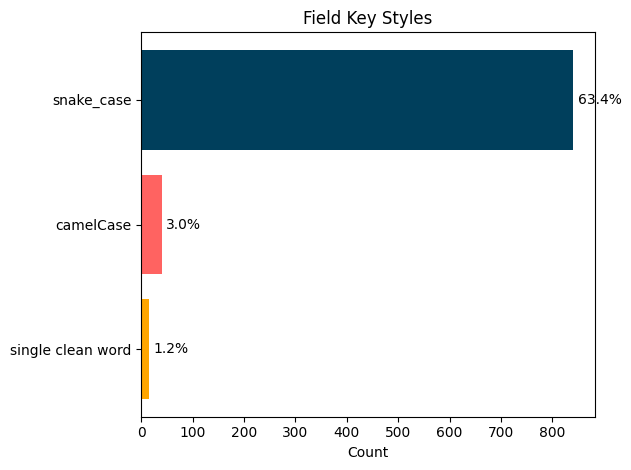

In [ ]:


# Plot horizontal bar chart
fig, ax = plt.subplots()
bars = ax.barh(summary["Style"], summary["Count"],color=["#003f5c", "#ff6361", "#ffa600"])

# Annotate each bar with percentage
for bar, pct in zip(bars, summary["Percent"]):
    width = bar.get_width()
    ax.text(width + max(summary["Count"])*0.01,   # a little to the right of the bar
            bar.get_y() + bar.get_height()/2,
            f"{pct:.1f}%",
            va="center")

ax.set_xlabel("Count")
ax.set_title("Field Key Styles")
ax.invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

# Save Plot
fig.savefig('output/field_key_style_distribution.png', dpi=300)


In [ ]:
structural_analysis = field_keys_df[['field_key', 'field_title', 'validity_stats', 'token_valid_ratio', 'char_valid_ratio', 'valid_tokens', 'invalid_tokens', 'tokens', 'token_validity_ratio_label', 'camel_case_flag', 'snake_case_flag', 'clean_word_flag', 'missing_field_title']]
structural_analysis.to_csv("output/field_keys_structural_analysis_results.csv", index=False)
field_keys_df.drop(columns=['validity_stats', 'char_valid_ratio', 'valid_tokens', 'tokens', 'camel_case_flag', 'snake_case_flag', 'clean_word_flag'], inplace=True)

In [ ]:
field_keys_df.head()

,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,missing_field_title,token_valid_ratio,invalid_tokens,token_validity_ratio_label
0,meeting_summary,סיכום הביקור,textarea,False,0,False,1.0,[],VALID
4,Patient_States,Patient states,textarea,False,4,False,1.0,[],VALID
7,Comments_Concerns,Comments or concerns about UDS,textarea,False,7,False,1.0,[],VALID
8,Narrative_Summary,Narrative summary,textarea,False,8,False,1.0,[],VALID
9,purpose,Purpose of Contact,textarea,False,9,False,1.0,[],VALID


In [ ]:
field_keys_df.shape

(1327, 9)

## Containment (Field Key - Field Title)

In [ ]:
nlp = spacy.load("en_core_web_sm")


STOPWORDS = {
    "the","a","an","of","and","or","to","for","in","on","at","by","with",
    "from","as","is","are","be","was","were","this","that","these","those"
}

SYNONYMS = {
    "info" : "information",
}


def _normalize(text: str) -> str:
    """Lowercase, split camelCase, replace _ and -, strip non-alphanum (keep spaces)."""
    if text is None:
        return ""
    s = str(text).strip()
    # split camelCase / PascalCase: ...aA... → ...a A...
    s = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', s)
    # lower
    s = s.lower()
    # turn _ and - into spaces
    s = re.sub(r'[_/-]', ' ', s)
    # remove other punctuation
    s = re.sub(r'[^a-z0-9\s]', '', s)
    # collapse spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def _apply_synonyms(tokens, synonyms):
    if not synonyms:
        return tokens
    return [synonyms.get(t, t) for t in tokens]


def spacy_lemmas(text: str) -> list[str]:
    if not text: return []
    doc = nlp(str(text))
    toks = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        lemma = tok.lemma_.lower().strip()
        if not lemma or lemma in STOPWORDS:
            continue
        toks.append(lemma)
    return toks


def overlap_scores(
    key: str,
    title: str,
    stopwords: set = STOPWORDS,
    synonyms: dict | None = None,
):
    """
    Compute several overlap metrics between a normalized field key and a title.
    Returns a dict with scores and matched tokens.
    """
    # normalize & tokenize
    key_norm   = _key_normalize(key)
    title_norm = _normalize(title)

    key_tokens   = _tokenize(key_norm)
    title_tokens = _tokenize(title_norm)


    # optional stopword removal
    if stopwords:
        key_tokens   = [t for t in key_tokens   if t not in stopwords]
        title_tokens = [t for t in title_tokens if t not in stopwords]

    # apply lemmatization
    key_tokens = spacy_lemmas(key_tokens)
    title_tokens = spacy_lemmas(title_tokens)

    # optional synonym mapping (e.g., {'dob':'date', 'zipcode':'zip'})
    key_tokens   = _apply_synonyms(key_tokens, synonyms=SYNONYMS)
    title_tokens = _apply_synonyms(title_tokens, synonyms=SYNONYMS)

    A = set(key_tokens)
    B = set(title_tokens)

    if not A and not B:
        return {
            "jaccard": 0.0,
            "containment_key": 0.0,
            "containment_title": 0.0,
            "overlap_coeff": 0.0,
            "matched": [],
            "key_tokens": [],
            "title_tokens": []
        }

    inter = A & B
    union = A | B

    # Jaccard: |A∩B| / |A∪B| (balanced)
    jaccard = len(inter) / len(union) if union else 0.0
    # Containment (your original idea): how much of key is in title
    containment_key = len(inter) / len(A) if A else 0.0
    # Reverse containment: how much of title is covered by key
    containment_title = len(inter) / len(B) if B else 0.0
    # Overlap coefficient (Szymkiewicz–Simpson): |∩| / min(|A|,|B|)
    overlap_coeff = len(inter) / min(len(A), len(B)) if A and B else 0.0

    return {
        "jaccard": round(jaccard, 4),
        "containment_key": round(containment_key, 4),
        "containment_title": round(containment_title, 4),
        "overlap_coeff": round(overlap_coeff, 4),
        "matched_tokens": list(inter),
        "key_tokens": list(A),
        "title_tokens": list(B),
    }


#### Test overlap_scores() function

In [ ]:
res = overlap_scores("Patient_FirstName", "Patient first name (legal)", synonyms=SYNONYMS)
print(res)

{'jaccard': 0.75, 'containment_key': 1.0, 'containment_title': 0.75, 'overlap_coeff': 1.0, 'matched_tokens': ['name', 'first', 'patient'], 'key_tokens': ['first', 'patient', 'name'], 'title_tokens': ['first', 'patient', 'name', 'legal']}


#### Apply Function

In [ ]:
results = field_keys_df.apply(
        lambda row: overlap_scores(row['field_key'], row['field_title'], STOPWORDS, SYNONYMS),
        axis=1
    )

# Convert series of dicts → dataframe
overlap_df = pd.DataFrame(list(results))

desired_metrics = overlap_df[['containment_title', 'matched_tokens', 'key_tokens','title_tokens']]

# Concatenate back to original df
field_keys_df = pd.concat(
    [(field_keys_df).reset_index(drop=True), desired_metrics],
    axis=1
)



In [ ]:
def categorize_containment_title(score: float,
                                 high_thresh: float = 0.80,
                                 low_thresh: float = 0.50) -> tuple[str, str]:
    """
    Categorize containment_title score into 'high' / 'partial' / 'low'.
    Returns (label, reason).
    """
    if score is None:
        return "LOW", "no score"
    try:
        ct = float(score)
    except Exception:
        return "LOW", "invalid score"

    if ct >= high_thresh:
        return "HIGH", f"coverage ≥ {high_thresh:.2f}"
    if ct >= low_thresh:
        return "PARTIAL", f"{low_thresh:.2f} ≤ coverage < {high_thresh:.2f}"
    return "LOW", f"coverage < {low_thresh:.2f}"


# Apply categorization to each row in your DataFrame
labels_reasons = field_keys_df["containment_title"].apply(categorize_containment_title)

field_keys_df["containment_title_label"]  = labels_reasons.map(lambda x: x[0])
field_keys_df["containment_title_reason"] = labels_reasons.map(lambda x: x[1])



In [ ]:
print(field_keys_df['containment_title_label'].value_counts())

containment_title_label
LOW        780
HIGH       314
PARTIAL    233
Name: count, dtype: int64


In [ ]:
text_overlap_analysis = field_keys_df[[
    'field_key', 'field_title', 'containment_title', 'matched_tokens', 'key_tokens', 'title_tokens', 'containment_title_label',
    'field_type', 'field_key_exists_in_library_flag', 'missing_field_title'
]]

text_overlap_analysis.to_csv('output/text_overlap_analysis.csv', index=False)
field_keys_df.drop(columns=['containment_title_reason'], inplace=True)

In [ ]:
field_keys_df.shape

(1327, 14)

## Cosine Similarity

In [ ]:
field_keys_df.head()

,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,missing_field_title,token_valid_ratio,invalid_tokens,token_validity_ratio_label,containment_title,matched_tokens,key_tokens,title_tokens,containment_title_label
0,meeting_summary,סיכום הביקור,textarea,False,0,False,1.0,[],VALID,0.0,[],"[meet, summary]",[],LOW
1,Patient_States,Patient states,textarea,False,4,False,1.0,[],VALID,1.0,"[state, patient]","[state, patient]","[state, patient]",HIGH
2,Comments_Concerns,Comments or concerns about UDS,textarea,False,7,False,1.0,[],VALID,0.5,"[comment, concern]","[comment, concern]","[about, comment, ud, concern]",PARTIAL
3,Narrative_Summary,Narrative summary,textarea,False,8,False,1.0,[],VALID,1.0,"[narrative, summary]","[narrative, summary]","[narrative, summary]",HIGH
4,purpose,Purpose of Contact,textarea,False,9,False,1.0,[],VALID,0.5,[purpose],[purpose],"[purpose, contact]",PARTIAL


### Prep text

In [ ]:
# 1) Load a lightweight, strong general model
# Good default for short phrases; fast on CPU
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
emb_model = SentenceTransformer(EMB_MODEL_NAME)

# 2) Helper: cosine similarity
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    # safe, handles zero vectors
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


# 3) Build the text we will embed
# Prefer lemmatized strings if you have them; else fall back to normalized strings
def make_embed_text(row) -> tuple[str, str]:
    # If you maintained lemma lists:
    key_lemmas   = row.get("key_tokens")   # e.g. ['purpose', 'contact']
    title_lemmas = row.get("title_tokens") # e.g. ['purpose', 'of', 'contact']
    if isinstance(key_lemmas, list) and isinstance(title_lemmas, list):
        key_text   = " ".join(key_lemmas)
        title_text = " ".join(title_lemmas)
    #else:
        # Fall back to your normalized strings
        #key_text   = str(row.get("normalized_field_key", row.get("field_key", "")))
        #title_text = str(row.get("normalized_field_title", row.get("field_title", "")))
    return key_text.strip(), title_text.strip()

# 4) Vectorize in batches (faster than row-by-row)
def compute_cosine_for_df(df: pd.DataFrame, batch_size: int = 64) -> pd.Series:
    texts = [make_embed_text(r) for _, r in df.iterrows()]
    key_texts   = [t[0] for t in texts]
    title_texts = [t[1] for t in texts]

    # Encode both sides
    key_embs   = emb_model.encode(key_texts, batch_size=batch_size, normalize_embeddings=False)
    title_embs = emb_model.encode(title_texts, batch_size=batch_size, normalize_embeddings=False)

    # Cosine per row
    cos = [cosine_sim(k, t) for k, t in zip(key_embs, title_embs)]
    return pd.Series(cos, index=df.index, name="cosine_sim")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# 5) Apply to your DataFrame
field_keys_df["cosine_sim"] = compute_cosine_for_df(field_keys_df)


In [ ]:
def cosine_bucket(x: float) -> str:
    if x >= 0.85:  return "HIGH"
    if x >= 0.41:  return "MEDIUM"
    return "LOW"

field_keys_df["cosine_verdict"] = field_keys_df["cosine_sim"].apply(cosine_bucket)
print(field_keys_df['cosine_verdict'].value_counts())

cosine_verdict
MEDIUM    605
LOW       491
HIGH      231
Name: count, dtype: int64


In [ ]:
cosine_similarity_analysis = field_keys_df[['field_key', 'field_title', 'containment_title', 'cosine_sim']]
cosine_similarity_analysis.to_csv('output/cosine_similarity_analysis.csv', index=False)

In [ ]:
import os
import pickle


# full path to pickle file
output_path = os.path.join(CACHE_DIR, "field_keys_df.pkl")

# write the DataFrame to pickle
with open(output_path, "wb") as f:
    pickle.dump(field_keys_df, f)


In [ ]:
field_keys_df.shape

(1327, 16)

## Natural Language Inference (NLI)

In [ ]:
output_path = os.path.join(CACHE_DIR, "field_keys_df.pkl")

In [ ]:
with open(output_path, "rb") as f:
    field_keys_df = pickle.load(f)


In [ ]:
field_keys_df = field_keys_df.copy()

In [ ]:
# test_nli.py (optional snippet to run in your notebook)
from nli_helpers import nli_probe_report

pairs = [
    ("progress", "Client progress since last session"),
    ("Purpose", "Purpose of Contact"),
    ("Diagnosis", "Client strengths"),
    ("treatment_plan", "Treatment Plan"),
    ("Provider_response", "Client response"),
]

df = nli_probe_report(pairs)
print(df)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                 key                               title      t2k_label  \
0           progress  Client progress since last session     entailment   
1            Purpose                  Purpose of Contact     entailment   
2          Diagnosis                    Client strengths  contradiction   
3     treatment_plan                      Treatment Plan     entailment   
4  Provider_response                     Client response  contradiction   

   t2k_conf      k2t_label  k2t_conf  
0  0.870750        neutral  0.991540  
1  0.783634        neutral  0.971568  
2  0.566884  contradiction  0.846645  
3  0.903289     entailment  0.898910  
4  0.951309  contradiction  0.940561  


In [ ]:

# Auto-run sanity on import
#try:
 #   _run_sanity_checks()
#except AssertionError as e:
 #   raise AssertionError(f"NLI axis sanity checks failed: {e}")


In [ ]:
from nli_apply import add_axis_columns_batched
from nli_helpers import _nli, _tok
print("NLI model:", getattr(_nli, "name_or_path", type(_nli).__name__))
print("id2label:", _nli.config.id2label)


NLI model: roberta-large-mnli
id2label: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}


In [ ]:
import importlib, nli_axis, nli_apply

importlib.reload(nli_axis)   # reload the source of combine_axis FIRST
importlib.reload(nli_apply)  # then reload the module that imports combine_axis

from nli_apply import add_axis_columns_batched   # re-import the function


field_keys_df = add_axis_columns_batched(field_keys_df, compute_k2t=False)


# Peek
field_keys_df[["field_key","field_title","nli_axis","nli_axis_label"]].head()

,field_key,field_title,nli_axis,nli_axis_label
0,meeting_summary,סיכום הביקור,-0.222507,Partial Contradiction
1,Patient_States,Patient states,0.740715,Exact Match
2,Comments_Concerns,Comments or concerns about UDS,0.359818,Weak Match
3,Narrative_Summary,Narrative summary,0.439683,Weak Match
4,purpose,Purpose of Contact,0.340273,Weak Match


In [ ]:

importlib.reload(nli_axis)  # picks up your new interpret_axis
field_keys_df["nli_axis_label"].value_counts()



,count
nli_axis_label,
Weak Match,486
Uncertain,480
Exact Match,267
Partial Contradiction,71
Strong Contradiction,23


In [ ]:
# Strong contradictions (different concepts)
strong_contra = field_keys_df.query("nli_axis_label == 'Strong Contradiction'") \
                   [["field_key","field_title","nli_axis"]] \
                   .sort_values("nli_axis")

weak_match = field_keys_df.query("nli_axis_label == 'Weak Match'") \
              [["field_key","field_title","nli_axis"]] \
              .sort_values("nli_axis")

# Partial contradictions (semantic tension)
partial = field_keys_df.query("nli_axis_label == 'Partial Contradiction'") \
              [["field_key","field_title","nli_axis"]] \
              .sort_values("nli_axis")

# Likely context-gap neutrals: scores just below zero
context_gapish = field_keys_df.query("nli_axis_label == 'Uncertain'") \
                    [["field_key","field_title","nli_axis"]] \
                    .sort_values("nli_axis")


# Exact matches (high-confidence entailment)
exact = field_keys_df.query("nli_axis_label == 'Exact Match'") \
           [["field_key","field_title","nli_axis"]] \
           .sort_values("nli_axis", ascending=False)


strong_contra[-10:]

,field_key,field_title,nli_axis
1118,housing_intervention,Content / Intervention and Progress,-0.277704
375,psych_7,Additional Observations:,-0.277361
1123,lincoln_next_steps,"Next Steps including, but not limited to, plan...",-0.269441
1175,hide_PLAN_header,,-0.268235
734,hide_PLAN_header,,-0.268234
903,crisis_presenting_text,Crisis Presenting Problem,-0.267896
378,psych_10,Progress:,-0.261635
371,psych_3,Family/Caregiver Observations:,-0.258000
864,Progresstextbox,Progress on treatment plan (ISP) goals since l...,-0.254529
433,objectivestb,Objectives that were addressed or need to be a...,-0.251176


In [ ]:
nli_analysis = field_keys_df[['field_key','field_title', 'nli_axis', 'nli_axis_label']]

nli_analysis.to_csv('output/nli_analysis.csv', index=False)

In [ ]:
# full path to pickle file
output_path = os.path.join(CACHE_DIR, "field_keys_df_with_nli.pkl")

# write the DataFrame to pickle
with open(output_path, "wb") as f:
    pickle.dump(field_keys_df, f)


In [ ]:
field_keys_df.shape

(1327, 18)

## Facet Detectors

In [ ]:
output_path = os.path.join(CACHE_DIR, "field_keys_df_with_nli.pkl")

In [ ]:
with open(output_path, "rb") as f:
    field_keys_df = pickle.load(f)


In [ ]:
import pandas as pd
import numpy as np

def count_tokens(cell):
    # Handle None/NaN
    if cell is None:
        return 0
    if isinstance(cell, float) and np.isnan(cell):
        return 0

    # Handle string: comma-separated
    if isinstance(cell, str):
        toks = [t.strip() for t in cell.split(",") if t.strip()]
        return len(toks)

    # Handle list or tuple
    if isinstance(cell, (list, tuple)):
        return len(cell)

    # Handle numpy array
    if isinstance(cell, np.ndarray):
        return len(cell)

    # Fallback
    return 0

# Apply to your DataFrame
field_keys_df
field_keys_df["key_tokens_count"] = field_keys_df["key_tokens"].apply(count_tokens)
field_keys_df["title_tokens_count"] = field_keys_df["title_tokens"].apply(count_tokens)

# len_ratio = title_tokens_count / key_tokens_count
denom = field_keys_df["key_tokens_count"].replace(0, 1)  # avoid divide-by-zero
field_keys_df["len_ratio"] = (field_keys_df["title_tokens_count"] / denom).astype(float).clip(upper=3.0)

field_keys_df[["key_tokens", "key_tokens_count", "title_tokens", "title_tokens_count", "len_ratio"]].head(10)
field_keys_df.drop(columns = ['key_tokens_count','title_tokens_count'], inplace = True)

In [ ]:
field_keys_df.head()

,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,missing_field_title,token_valid_ratio,invalid_tokens,token_validity_ratio_label,containment_title,matched_tokens,key_tokens,title_tokens,containment_title_label,cosine_sim,cosine_verdict,nli_axis,nli_axis_label,len_ratio
0,meeting_summary,סיכום הביקור,textarea,False,0,False,1.0,[],VALID,0.0,[],"[meet, summary]",[],LOW,0.213886,LOW,-0.222507,Partial Contradiction,0.0
1,Patient_States,Patient states,textarea,False,4,False,1.0,[],VALID,1.0,"[state, patient]","[state, patient]","[state, patient]",HIGH,1.000000,HIGH,0.740715,Exact Match,1.0
2,Comments_Concerns,Comments or concerns about UDS,textarea,False,7,False,1.0,[],VALID,0.5,"[comment, concern]","[comment, concern]","[about, comment, ud, concern]",PARTIAL,0.717686,MEDIUM,0.359818,Weak Match,2.0
3,Narrative_Summary,Narrative summary,textarea,False,8,False,1.0,[],VALID,1.0,"[narrative, summary]","[narrative, summary]","[narrative, summary]",HIGH,1.000000,HIGH,0.439683,Weak Match,1.0
4,purpose,Purpose of Contact,textarea,False,9,False,1.0,[],VALID,0.5,[purpose],[purpose],"[purpose, contact]",PARTIAL,0.637210,MEDIUM,0.340273,Weak Match,2.0


In [ ]:
import numpy as np
import pandas as pd

# ---- Config knobs (tune here) -----------------------------------------------
cfg = dict(
    # NLI & cosine thresholds
    strong_contra_cut=-0.25,
    partial_contra_cut=-0.15,
    cosine_strong=0.85,
    cosine_partial=0.41,

    # Containment labels considered "low coverage"
    low_containment="LOW",
    partial_containment= "PARTIAL",
    good_containment="HIGH",

    # Missing context heuristic
    len_ratio_threshold=1.50,  # title_tokens / key_tokens
    len_ratio_high=2.00,
    min_matched_tokens=1,

    # Token validity
    token_ratio_ok=0.85,
    token_ratio_bad=0.70,

    # Not-in-library severity helper
    notinlib_cosine_low=0.45,
    notinlib_nli_neg=-0.20,

    # Label strings (keep consistent)
    LBL_EXACT="Exact Match",
    LBL_WEAK="Weak Match",
    LBL_UNCERTAIN="Uncertain",
    LBL_PARTIAL="Partial Contradiction",
    LBL_STRONG="Strong Contradiction",
)


def _clamp(x, lo=-1.0, hi=1.0):
    return max(lo, min(hi, float(x)))


In [ ]:
# ---- Derived helpers -----------------------------------------------------
# Safe fill/normalize for labels we use in rules
field_keys_df["nli_axis_label"] = field_keys_df["nli_axis_label"].fillna(cfg["LBL_UNCERTAIN"])
field_keys_df["containment_title_label"] = field_keys_df["containment_title_label"].fillna("NONE")


print(field_keys_df['nli_axis_label'].value_counts())
print(field_keys_df['containment_title_label'].value_counts())

nli_axis_label
Weak Match               486
Uncertain                480
Exact Match              267
Partial Contradiction     71
Strong Contradiction      23
Name: count, dtype: int64
containment_title_label
LOW        780
HIGH       314
PARTIAL    233
Name: count, dtype: int64


In [ ]:
# ---- Facets (booleans) ---------------------------------------------------
# 1) Different Concepts (hard mismatch)
field_keys_df["facet_hard_mismatch"] = (
  (field_keys_df["nli_axis"] <= cfg["strong_contra_cut"]) |
  ((field_keys_df["containment_title_label"] == cfg["low_containment"]) & (field_keys_df["cosine_sim"] < cfg["cosine_partial"]))
)


# 2) Partial Mismatch (semantic tension)
field_keys_df["facet_partial_mismatch"] = (
    ((field_keys_df["nli_axis"] > cfg["strong_contra_cut"]) & (field_keys_df["nli_axis"] <= cfg["partial_contra_cut"])) |
    ((field_keys_df["containment_title_label"] == cfg["partial_containment"]) & (field_keys_df["cosine_sim"] < cfg["cosine_partial"]))|
    ((field_keys_df["containment_title_label"] == cfg["low_containment"]) & ((field_keys_df["cosine_sim"] < cfg["cosine_strong"]) & (field_keys_df["cosine_sim"]> cfg["cosine_partial"])))
) & ~field_keys_df["facet_hard_mismatch"]



# 3) Missing Context (key too generic vs title)
field_keys_df["facet_missing_context"] = (
  (field_keys_df["len_ratio"] >= cfg["len_ratio_threshold"]) &
  (field_keys_df["matched_tokens"].apply(count_tokens) >= cfg["min_matched_tokens"]) &
  (field_keys_df["nli_axis_label"].isin([cfg["LBL_UNCERTAIN"], cfg["LBL_WEAK"]])) &
   ~(field_keys_df["facet_hard_mismatch"] | field_keys_df["facet_partial_mismatch"])
)


condition = field_keys_df['facet_missing_context']
field_keys_df[condition][['field_key', 'field_title', 'nli_axis','containment_title_label','cosine_sim','facet_missing_context']]

,field_key,field_title,nli_axis,containment_title_label,cosine_sim,facet_missing_context
2,Comments_Concerns,Comments or concerns about UDS,0.359818,PARTIAL,0.717686,True
4,purpose,Purpose of Contact,0.340273,PARTIAL,0.637210,True
5,response,Client Response,0.475051,PARTIAL,0.540540,True
13,changes_consumer,Changes in the consumer's condition or situation,0.575400,PARTIAL,0.734115,True
15,chief,Chief Complaint,0.285660,PARTIAL,0.690979,True
...,...,...,...,...,...,...
1264,focus,Focus of Session,0.369141,PARTIAL,0.672397,True
1272,response,Response to Interventions,0.462161,PARTIAL,0.568102,True
1305,follow_up,What follow up is needed,0.595521,PARTIAL,0.725011,True
1309,response,Response to Intervention,0.515423,PARTIAL,0.568102,True


In [ ]:

# --- small lexicons (extend later)
ACTOR_LEX = {
    "client","patient","member","consumer","provider","therapist","clinician",
    "counselor","peer","supervisor","family","caregiver","staff"
}
TEMPORAL_LEX = {
    "session","since","during","today","yesterday","tomorrow",
    "last","next","week","month","year","annual","date","time","visit"
}

# --- robust token reader (works for list/tuple/ndarray/comma-separated string)
def _tokens_from_cell(cell):
    if cell is None:
        return []
    if isinstance(cell, (list, tuple)):
        return [str(t).lower() for t in cell]
    try:
        import numpy as _np
        if isinstance(cell, _np.ndarray):
            return [str(t).lower() for t in cell.tolist()]
    except Exception:
        pass
    s = str(cell).strip()
    if not s or s.lower() in {"nan","none"}:
        return []
    s = s.replace("[","").replace("]","").replace("'","")
    return [t.strip().lower() for t in s.split(",") if t.strip()]

def _has_lexicon_hit(tokens, lex):
    if not tokens:
        return False
    tset = set(tokens)
    return any(w in tset for w in lex)

def _count_lex_hits(tokens, lex):
    if not tokens:
        return 0
    return sum(1 for t in tokens if t in lex)

# --- normalize token columns to lists of lowercase strings
key_toks   = field_keys_df["key_tokens"].apply(_tokens_from_cell)
title_toks = field_keys_df["title_tokens"].apply(_tokens_from_cell)

# --- compute lexicon hits
field_keys_df["key_actor_hits"]   = key_toks.apply(lambda ts: _count_lex_hits(ts, ACTOR_LEX))
field_keys_df["title_actor_hits"] = title_toks.apply(lambda ts: _count_lex_hits(ts, ACTOR_LEX))

field_keys_df["key_temporal_hit"]   = key_toks.apply(lambda ts: _has_lexicon_hit(ts, TEMPORAL_LEX))
field_keys_df["title_temporal_hit"] = title_toks.apply(lambda ts: _has_lexicon_hit(ts, TEMPORAL_LEX))

# --- gate: NLI not strongly negative AND title present
# (your condition: nli_axis >= -0.15 and not missing_field_title)
gate = (field_keys_df["nli_axis"].astype(float) >= -0.15) & (~field_keys_df["missing_field_title"].astype(bool))

# --- facets
field_keys_df["facet_hidden_agent"] = gate & (field_keys_df["title_actor_hits"] > field_keys_df["key_actor_hits"])
field_keys_df["facet_temporal_mismatch"] = gate & (field_keys_df["title_temporal_hit"] & ~field_keys_df["key_temporal_hit"])


condition = field_keys_df['facet_hidden_agent']
field_keys_df[condition][['field_key', 'field_title', 'nli_axis','containment_title_label','cosine_sim','facet_hidden_agent']]




,field_key,field_title,nli_axis,containment_title_label,cosine_sim,facet_hidden_agent
5,response,Client Response,0.475051,PARTIAL,0.540540,True
6,explanation,"Explanation (use direct quotes from Client, wh...",0.434662,LOW,0.144048,True
21,issues,Personal/Family/Social History/Legal Issues,0.560503,LOW,0.270063,True
22,fam_history,Family History (Biological Loading),0.485025,LOW,0.356963,True
40,information_text,New Salient Information provided by client/fam...,0.001586,LOW,0.296771,True
...,...,...,...,...,...,...
1223,response_text,Client Response/Assessment,0.151392,LOW,0.499781,True
1275,Interventionstextbox,Interventions used and client's response to tr...,-0.143147,LOW,0.444295,True
1281,Interventionstextbox,Interventions used and client's response to tr...,-0.135363,LOW,0.444295,True
1286,Interventionstextbox,Describe interventions used and manner of deli...,-0.107571,LOW,0.408432,True


In [ ]:

# 6) Token Validity Issues
field_keys_df["facet_token_validity_issues"] = (
    (field_keys_df["token_valid_ratio"]< 1) |
    (field_keys_df["invalid_tokens"].apply(count_tokens)>=1)
)

# 7) Title Missing
field_keys_df["facet_title_missing"] = field_keys_df["missing_field_title"] == True

condition = field_keys_df['facet_token_validity_issues']
field_keys_df[condition][['field_key', 'field_title', 'token_valid_ratio', 'invalid_tokens','facet_token_validity_issues']]






,field_key,field_title,token_valid_ratio,invalid_tokens,facet_token_validity_issues
11,additionalcommentstext,Comments:,0.0,[additionalcommentstext],True
18,prev_meds,Medications Previously Tried (if any),0.5,[prev],True
37,therapy_recs,Therapeutic Recommendations,0.5,[recs],True
38,clin_interpretations,Clinical Interpretation,0.5,[clin],True
57,sud_symptoms,Symptoms/Problems Status (incl. changes in Cir...,0.5,[sud],True
...,...,...,...,...,...
1291,treatmentgoaltb,Goals for treatment: (what do you hope will be...,0.0,[treatmentgoaltb],True
1292,psychoeducationtb,Psychoeducation provided: (information about d...,0.0,[psychoeducationtb],True
1293,treatmentbarriertb,Possible barrier to treatment: (transportation...,0.0,[treatmentbarriertb],True
1294,plantb,Plan: (Next steps for starting therapy services),0.0,[plantb],True


In [ ]:
def semantic_severity(row):
    nli_norm = (float(row["nli_axis"]) + 1.0) / 2.0   # [-1,1] → [0,1]
    cos_norm = float(row["cosine_sim"])               # already [0,1]
    cont_norm = float(row["containment_title"])       # already [0,1]

    # Weighted average
    score = 0.6 * nli_norm + 0.3 * cos_norm + 0.1 * cont_norm
    return max(0.0, min(1.0, score))   # clamp


# Apply to DataFrame
field_keys_df["semantic_severity"] = field_keys_df.apply(semantic_severity, axis=1)
print(f"Semantic severity range: min={field_keys_df['semantic_severity'].min():.4f}, max={field_keys_df['semantic_severity'].max():.4f}")



MISSING_TITLE_PENALTY = 1.0  # 1.0 => sets to 0 when title missing

structural = field_keys_df["token_valid_ratio"].astype(float).clip(0,1)
structural = np.where(field_keys_df["missing_field_title"].fillna(False).astype(bool),
                      np.maximum(0.0, structural - MISSING_TITLE_PENALTY),
                      structural)


field_keys_df["structural_severity"] = structural


field_keys_df["final_severity"] = (
    0.3 * field_keys_df["semantic_severity"].astype(float) +
    0.7 * field_keys_df["structural_severity"].astype(float)
).clip(0.0, 1.0)


Semantic severity range: min=0.2397, max=0.9777


In [ ]:
field_keys_df.columns

Index(['field_key', 'field_title', 'field_type',
       'field_key_exists_in_library_flag', 'row_id', 'missing_field_title',
       'token_valid_ratio', 'invalid_tokens', 'token_validity_ratio_label',
       'containment_title', 'matched_tokens', 'key_tokens', 'title_tokens',
       'containment_title_label', 'cosine_sim', 'cosine_verdict', 'nli_axis',
       'nli_axis_label', 'len_ratio', 'facet_hard_mismatch',
       'facet_partial_mismatch', 'facet_missing_context', 'key_actor_hits',
       'title_actor_hits', 'key_temporal_hit', 'title_temporal_hit',
       'facet_hidden_agent', 'facet_temporal_mismatch',
       'facet_token_validity_issues', 'facet_title_missing',
       'semantic_severity', 'structural_severity', 'final_severity'],
      dtype='object')

In [ ]:
import pandas as pd

# Identify facet columns automatically (those starting with "facet_")
facet_cols = [c for c in field_keys_df.columns if c.startswith("facet_")]

def collect_facets(row):
    # Only read from the facet columns, never alter them
    facet_values = row[facet_cols]
    active = [col.replace("facet_", "") for col, val in facet_values.items() if bool(val)]
    return ", ".join(active) if active else None

# Create a new 'reasons' column while leaving facet columns untouched
field_keys_df["reasons"] = field_keys_df.apply(collect_facets, axis=1)


# facet_cols was created earlier, e.g.:
# facet_cols = [c for c in field_keys_df.columns if c.startswith("facet_")]

cols_to_drop = [
    "key_temporal_hit", "title_temporal_hit",
    "key_actor_hits", "title_actor_hits",
]

field_keys_df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

In [ ]:
field_keys_df.head()

,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,missing_field_title,token_valid_ratio,invalid_tokens,token_validity_ratio_label,containment_title,...,facet_partial_mismatch,facet_missing_context,facet_hidden_agent,facet_temporal_mismatch,facet_token_validity_issues,facet_title_missing,semantic_severity,structural_severity,final_severity,reasons
0,meeting_summary,סיכום הביקור,textarea,False,0,False,1.0,[],VALID,0.0,...,False,False,False,False,False,False,0.297414,1.0,0.789224,hard_mismatch
1,Patient_States,Patient states,textarea,False,4,False,1.0,[],VALID,1.0,...,False,False,False,False,False,False,0.922214,1.0,0.976664,None
2,Comments_Concerns,Comments or concerns about UDS,textarea,False,7,False,1.0,[],VALID,0.5,...,False,True,False,False,False,False,0.673251,1.0,0.901975,missing_context
3,Narrative_Summary,Narrative summary,textarea,False,8,False,1.0,[],VALID,1.0,...,False,False,False,False,False,False,0.831905,1.0,0.949572,None
4,purpose,Purpose of Contact,textarea,False,9,False,1.0,[],VALID,0.5,...,False,True,False,False,False,False,0.643245,1.0,0.892973,missing_context


In [ ]:
field_keys_df.to_csv("output/field_keys_df_full_analysis.csv", index= False)

In [ ]:
analysis = field_keys_df[['field_key', 'field_title', 'semantic_severity', 'structural_severity', 'final_severity', 'reasons']]

In [ ]:
field_keys_df.head()

,field_key,field_title,field_type,field_key_exists_in_library_flag,row_id,missing_field_title,token_valid_ratio,invalid_tokens,token_validity_ratio_label,containment_title,...,facet_partial_mismatch,facet_missing_context,facet_hidden_agent,facet_temporal_mismatch,facet_token_validity_issues,facet_title_missing,semantic_severity,structural_severity,final_severity,reasons
0,meeting_summary,סיכום הביקור,textarea,False,0,False,1.0,[],VALID,0.0,...,False,False,False,False,False,False,0.297414,1.0,0.789224,hard_mismatch
1,Patient_States,Patient states,textarea,False,4,False,1.0,[],VALID,1.0,...,False,False,False,False,False,False,0.922214,1.0,0.976664,None
2,Comments_Concerns,Comments or concerns about UDS,textarea,False,7,False,1.0,[],VALID,0.5,...,False,True,False,False,False,False,0.673251,1.0,0.901975,missing_context
3,Narrative_Summary,Narrative summary,textarea,False,8,False,1.0,[],VALID,1.0,...,False,False,False,False,False,False,0.831905,1.0,0.949572,None
4,purpose,Purpose of Contact,textarea,False,9,False,1.0,[],VALID,0.5,...,False,True,False,False,False,False,0.643245,1.0,0.892973,missing_context


In [ ]:

field_keys

,report_class_id,field_key,field_title,field_type,field_key exists in field_key_library?,field_key_definition,row_id
0,AmalReport,meeting_summary,סיכום הביקור,textarea,False,NaN,0
1,APNFamilyTherapyReport,data,Data:,textarea,True,The Field ‘data' contains the main topics cove...,1
2,APNFamilyTherapyReport,assessment,Assessment:,textarea,True,This field captures the thorough analysis or e...,2
3,APNFamilyTherapyReport,plan,Plan:,textarea,True,This field describes the future steps or actio...,3
4,ARCAIndividualTherapyNoteReport,Patient_States,Patient states,textarea,False,NaN,4
...,...,...,...,...,...,...,...
2820,ZepfIndividualTherapyServiceNote,interventions,Describe the interventions provided.,textarea,True,The Field ‘interventions' refers to the variou...,2820
2821,ZepfIndividualTherapyServiceNote,client_response,Describe the client's response to the interven...,textarea,False,NaN,2821
2822,ZepfIndividualTherapyServiceNote,plan_document,Document the plan. If there were barriers desc...,textarea,False,NaN,2822
2823,ZepfTbsOutreachReport,intervention_description_and_narrative,Describe Interventions Delivered:,textarea,False,NaN,2823


In [ ]:
# Build your analysis frame with row_id included
#analysis = field_keys_df[[
 #   "row_id", "semantic_severity", "structural_severity", "final_severity", "reasons"
#]].copy()

# Safe left join back to the original rows
merged = field_keys.merge(
    field_keys_df, on="row_id", how="left", validate="one_to_one"  # will raise if duplicated row_id appears
)



print("field_keys rows:", len(field_keys))
print("merged rows:", len(merged))  # should match field_keys rows now

merged.to_csv("output/final_df.csv", index= False)
merged.head()

field_keys rows: 2825
merged rows: 2825


,report_class_id,field_key_x,field_title_x,field_type_x,field_key exists in field_key_library?,field_key_definition,row_id,field_key_y,field_title_y,field_type_y,...,facet_partial_mismatch,facet_missing_context,facet_hidden_agent,facet_temporal_mismatch,facet_token_validity_issues,facet_title_missing,semantic_severity,structural_severity,final_severity,reasons
0,AmalReport,meeting_summary,סיכום הביקור,textarea,False,NaN,0,meeting_summary,סיכום הביקור,textarea,...,False,False,False,False,False,False,0.297414,1.0,0.789224,hard_mismatch
1,APNFamilyTherapyReport,data,Data:,textarea,True,The Field ‘data' contains the main topics cove...,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APNFamilyTherapyReport,assessment,Assessment:,textarea,True,This field captures the thorough analysis or e...,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,APNFamilyTherapyReport,plan,Plan:,textarea,True,This field describes the future steps or actio...,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARCAIndividualTherapyNoteReport,Patient_States,Patient states,textarea,False,NaN,4,Patient_States,Patient states,textarea,...,False,False,False,False,False,False,0.922214,1.0,0.976664,None
